## Preamble

In [1]:
#Data Science Tools
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,precision_recall_curve, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sn
import matplotlib.pyplot as plt

#Pytorch
import torch
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

#additional tools
import os
import copy
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

In [2]:
# helper functions

# Focal loss with class weights. gamma=0 and alpha=.5 returns regular cross entropy loss.
def binary_focal_loss(y_pred , y_true ,gamma=2.0 , alpha=.8):
    pos_pt = y_pred[y_true==1]
    neg_pt = 1-y_pred[y_true==0]
    pos = alpha*(-torch.log(pos_pt+1e-9))*(1-pos_pt)**gamma
    neg = (1-alpha)*(-torch.log(neg_pt+1e-9))*(1-neg_pt)**gamma

    loss = torch.cat([pos,neg])
    return 2*loss.mean()


def plot_cm(test_y, pred_y):
    # pretty confusion matrix
    cm=(confusion_matrix(test_y, pred_y))
    cm=pd.DataFrame(cm, index = ['True Benign', 'True DOS'],
                    columns = ['Pred Benign', 'Pred DOS'])
    plt.figure(figsize = (10,7))
    fig, ax = plt.subplots(facecolor='w')
    sn.heatmap(cm, annot=True,fmt='g')

def plot_PR_Curve(true,predicted):
    precision=[]
    recall=[]
    f1=[]
    support=[]
    thresholds=np.linspace(0,1,100)
    for threshold in (thresholds):
        p,r,f,s=precision_recall_fscore_support(true,(predicted>threshold).astype('int'),average='binary')
        precision.append(p)
        recall.append(r)
        f1.append(f)
   
    precision = np.asarray(precision)
    precision[precision==0]=np.nan

    recall = np.asarray(recall)
    recall[recall==0]=np.nan

    plt.scatter(recall,precision)
    plt.show()
    return precision,recall,f1,thresholds





In [3]:
# Use GPU instead of CPU
use_cuda = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
device

device(type='cuda')

In [6]:
seed = 1337
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [8]:

# Import files from google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
#change directory
try:
  os.mkdir('/content/gdrive/My Drive/Cyber_workshop') # MTR
except:
  pass
os.chdir('/content/gdrive/My Drive/Cyber_workshop')
#

## DoS Source Data

In [10]:
os.listdir()

['UNSW_NB15_training-set.csv',
 'UNSW_NB15_testing-set.csv',
 'model_state_dict',
 'Wednesday-workingHours.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv']

In [11]:
# Import Source Model training and test data
df = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')

In [12]:
# Get feature stats for normalization
df_stats = pd.DataFrame(df.describe())

In [13]:
# features of interest


features = ["dur","spkts","dpkts", "sinpkt", "dinpkt","sload","dload"]

for f in features:


  df[f] = (df[f]-df_stats[f].loc['min'])/(df_stats[f].loc['max']-df_stats[f].loc['min'])
  test[f] = (test[f]-df_stats[f].loc['min'])/(df_stats[f].loc['max']-df_stats[f].loc['min'])

  

In [14]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.002025,tcp,-,FIN,0.000520,0.000364,258,172,74.087490,252,254,2.364553e-06,0.000379,0,0,0.000288,0.000148,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.010832,tcp,-,FIN,0.001352,0.003463,734,42014,78.473372,62,252,1.401989e-06,0.022458,2,17,0.000592,0.000272,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,0.027052,tcp,-,FIN,0.000728,0.001458,364,13186,14.170161,62,252,2.625704e-07,0.002717,1,6,0.002748,0.001811,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,0.028027,tcp,ftp,FIN,0.001144,0.001093,628,770,13.677108,62,252,4.576117e-07,0.000150,1,3,0.001812,0.001591,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.007491,tcp,-,FIN,0.000936,0.000547,534,268,33.373826,254,252,1.429776e-06,0.000178,2,1,0.000566,0.001334,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [15]:
# Filter for benign traffic and DoS attacks
df = df[df.attack_cat.isin(['DoS','Normal'])]
test = test[test.attack_cat.isin(['DoS','Normal'])]

In [16]:
df.attack_cat.value_counts()

Normal    56000
DoS       12264
Name: attack_cat, dtype: int64

In [17]:

print("percentage of malicious data samples: ",len(df[df.attack_cat=='DoS'])/float(len(df)))

percentage of malicious data samples:  0.17965545529122232


In [18]:
train_x, val_x, train_y, val_y = \
train_test_split(df[features].to_numpy(), df['label'].to_numpy(), test_size=0.2, random_state=1337)

In [19]:
# convert training data to pytorch tensors
train_x = torch.tensor(train_x).type(torch.FloatTensor)
train_y = torch.tensor(train_y).type(torch.FloatTensor)
#create a dataloader for batch training
train_dataset = data.TensorDataset(train_x,train_y)
train_dataloader = data.DataLoader(train_dataset,batch_size=512,shuffle=True) 

# convert validation data to pytorch tensors

val_x = torch.tensor(val_x).type(torch.FloatTensor)
val_y = torch.tensor(val_y).type(torch.FloatTensor)
val_dataset = data.TensorDataset(val_x,val_y) 
val_dataloader = data.DataLoader(val_dataset,batch_size=512,shuffle=True) 

In [20]:

test_x = torch.tensor(test[features].to_numpy()).type(torch.FloatTensor)
test_y = torch.tensor(test['label'].to_numpy()).type(torch.FloatTensor)

## DoS Source Model

In [21]:
class DoS_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_layers = nn.Sequential(
            nn.Linear(7, 4),
            nn.ReLU(),
            # nn.BatchNorm1d(4),
            nn.Linear(4, 4),
            nn.ReLU(),
        )


        self.classifier = nn.Sequential(
            nn.Linear(4, 1),          
        )

    
    def forward(self, x):
        features = self.model_layers(x)
        classification = torch.sigmoid(self.classifier(features))
        return classification

In [22]:
gamma=2
alpha=.8

[0.0002399924795841344]
epoch:  140


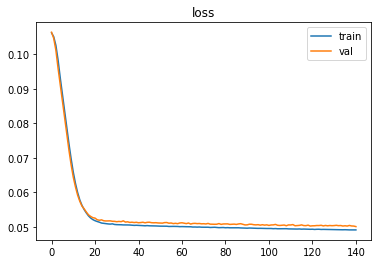

In [23]:
# Instantiate the model
model = DoS_Classifier().to(device) # cuda needed to ensure training on GPU. all inputs and models must be converted to cuda

#Create loss function (if using BCE) and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# for tracking loss
loss_history = []
val_loss_history = []
scheduler = optim.lr_scheduler.StepLR(optimizer, 1,gamma=.99)

for epoch in (range(150)):  # loop over the dataset multiple times
    train_epoch_loss = []
    val_epoch_loss = []
    for i, batch in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs=inputs.to(device) # cuda needed to ensure training on GPU. all inputs and models must be converted to cuda
        labels= labels.unsqueeze(1).to(device) 

        ##TO BE ADDED IN FOR PART 2 - ADVERSARIAL DOMAIN ADAPTATION
        # for p in model.parameters():
        #     if(len(p.data)>1):
        #         p.data.clamp_(-1.0, 1.0)


        # zero the parameter gradients
        optimizer.zero_grad()

        # # forward 
        outputs = model(inputs)
        #backward + optimize
        # loss = criterion(outputs, labels)
        # focal_loss to be used after BCE to compare performance
        loss = binary_focal_loss(outputs,labels,gamma=gamma,alpha=alpha)
       
        loss.backward()
        optimizer.step()  
        train_epoch_loss.append(loss.item())

    loss_history.append(sum(train_epoch_loss)/float(len(train_epoch_loss)))
    
    # Check validation data
    for i, batch in enumerate(val_dataloader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device) 
        outputs = model(inputs)
        # val_loss = criterion(outputs, labels)

        val_loss = binary_focal_loss(outputs,labels,gamma=gamma,alpha=alpha)
        val_epoch_loss.append(val_loss.item())
    val_loss_history.append(sum(val_epoch_loss)/float(len(val_epoch_loss)))
    scheduler.step()

    #plot every 10 epochs
    if epoch % 10 == 0:


        clear_output()
        print(scheduler.get_lr())
        print("epoch: ", epoch)
        plt.plot(range(epoch+1),loss_history,range(epoch+1),val_loss_history)
        plt.legend(['train','val'])
        plt.title('loss')
        plt.show()
        

In [24]:
torch.save(model.state_dict(), "model_state_dict")

In [25]:
# Get predictions - note cuda values need to be moved off gpu and to numpy with .cpu().data.numpy()
pred_y=model(test_x.to(device)).cpu().data.numpy()

In [26]:
threshold=.5

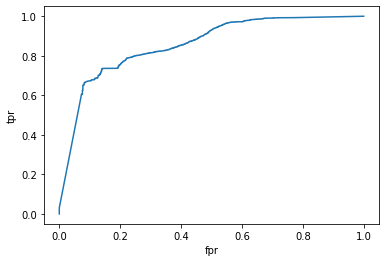

In [27]:

# Plot ROC curve, realize it's useless.

fpr, tpr, _ = roc_curve(test_y, (pred_y))
fig, ax = plt.subplots(facecolor='w')
plt.xlabel("fpr")
plt.ylabel("tpr")


ax.plot(fpr,tpr)

<Figure size 720x504 with 0 Axes>

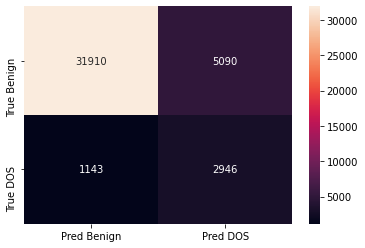

In [28]:
plot_cm(test_y,(pred_y>.5).astype(int))

In [29]:

# Check precision, recall, F1
precision_recall_fscore_support(test_y.cpu().data,(pred_y>.6).astype(int),average='binary')

(0.3922883487007544, 0.6867204695524578, 0.49933315550813545, None)

(array([1.3453e+04, 1.0060e+03, 2.9600e+03, 1.5630e+04, 5.5300e+02,
        1.6980e+03, 5.6740e+03, 1.4000e+01, 2.9000e+01, 7.2000e+01]),
 array([0.16301738, 0.24670881, 0.33040023, 0.41409168, 0.4977831 ,
        0.58147454, 0.66516596, 0.7488574 , 0.83254886, 0.9162403 ,
        0.9999317 ], dtype=float32),
 <a list of 10 Patch objects>)

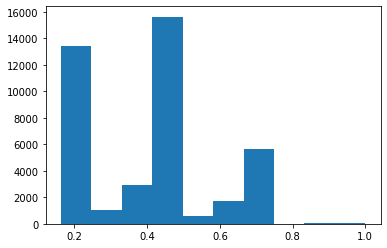

In [30]:
plt.hist(pred_y)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


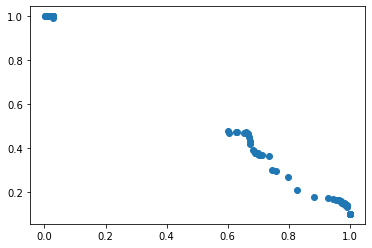

In [31]:

p,r,f,t = plot_PR_Curve(test_y.cpu().data,pred_y)

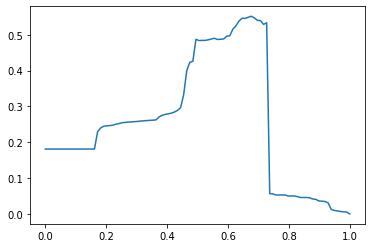

In [32]:

plt.plot(t,f)

## DoS Target data

In [33]:
#wednesday=pd.read_csv('MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv',low_memory=False)
wednesday=pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv',low_memory=False)

In [34]:
#monday=pd.read_csv('MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv',low_memory=False)
monday=pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv',low_memory=False)

In [35]:
target=pd.concat([monday,wednesday])
target.columns=[c.replace(" ",'') for c in target.columns]
target.Label[~(target.Label=="BENIGN")]=1
target.Label[(target.Label=="BENIGN")]=0
target.Label=target.Label.astype('int64')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
target.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,3000000.0,5.000000e+05,4.0,0.0,4,4,4,4.0,0.0,4,4,0,0.0,0.0,0,0,0,0,0,0,40,0,5.000000e+05,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,12000000.0,2.000000e+06,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0.0,0.0,0,0,0,0,0,0,40,0,2.000000e+06,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,329,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4000000.0,6.666667e+05,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,6.666667e+05,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,245,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [37]:
target.Label.unique()

array([0, 1])

In [38]:
target["dur"] = target['FlowDuration']
target["spkts"] = target['TotalFwdPackets']
target["dpkts"] = target['TotalBackwardPackets']
target['sinpkt'] = target['FwdIATMean']
target['dinpkt'] = target['BwdIATMean']
target['sload'] = target['FwdPackets/s']*target['TotalLengthofFwdPackets']/(1+target['TotalFwdPackets'])
target['dload'] = target['FwdPackets/s']*target['TotalLengthofBwdPackets']/(1+target['TotalBackwardPackets'])


In [39]:
print("percentage of malicious data samples: ",len(target[target.Label== 1])/float(len(target)))

percentage of malicious data samples:  0.20666420746903577


In [40]:
df_stats_target = pd.DataFrame(target.describe())

In [41]:
# df_stats_target = df_stats

In [42]:
features = ["dur","spkts","dpkts", "sinpkt", "dinpkt","sload","dload"]
for f in features:
  target[f] = (target[f]-df_stats_target[f].loc['min'])/(df_stats_target[f].loc['max']-df_stats_target[f].loc['min'])

In [43]:
target = target[features+['Label']]

In [44]:
target = target[~(target.isnull())]

In [45]:
train_x_target = torch.tensor(target[features].to_numpy()).type(torch.FloatTensor)
train_y_target = torch.tensor(target['Label'].to_numpy()).type(torch.FloatTensor)
train_dataset_target = data.TensorDataset(train_x_target,train_y_target) 
train_dataloader_target = data.DataLoader(train_dataset_target,batch_size=1024,shuffle=True) 

In [46]:
pred_y_target = model(train_x_target.cuda()).data.cpu().numpy()


In [47]:
precision_recall_fscore_support(train_y_target.cpu().data,(pred_y_target>.5).astype('int'),average='binary')

(0.3329988886144727, 0.17075892857142858, 0.22575345332775218, None)

## Adversarial Domain Adaption

In [48]:
source_model = DoS_Classifier().to(device)
source_model.load_state_dict(torch.load('model_state_dict'))
source_model.eval()
for param in source_model.parameters():
    param.requires_grad = False
retrained_target_model = source_model
source_model = source_model.model_layers

target_model = DoS_Classifier().to(device)
target_model.load_state_dict(torch.load('model_state_dict'))
target_model = target_model.model_layers


In [49]:
for param in target_model.parameters():
    print(param.requires_grad)

for param in source_model.parameters():
    print(param.requires_grad)

True
True
True
True
False
False
False
False


In [50]:
class adaption(nn.Module):
    def __init__(self):
        super(adaption, self).__init__()
        self.bn1=nn.BatchNorm1d(4)
        # self.bn2=nn.BatchNorm1d(4)


        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 4)
        self.fc3 = nn.Linear(4, 1)



    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
       
        x =  F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [51]:

def get_gradient_penalty(model, source_data, target_data):
    BATCH_SIZE=len(source_data)
    t = torch.rand(BATCH_SIZE, 1)
    t = t.expand(source_data.size())
    t = t.to(device)

    interpolation = t * source_data + ((1 - t) * target_data)

    interpolation = interpolation.to(device)
    interpolation = autograd.Variable(interpolation, requires_grad=True)

    discriminator_interpolation = model(interpolation)

    gradients = autograd.grad(outputs=discriminator_interpolation, inputs=interpolation, grad_outputs=torch.ones(discriminator_interpolation.size()).to(device),create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() 
    return gradient_penalty

[0.0001]
(0.1268585709208882, 0.35036727456940225, 0.18627277700627026, None)
best F1:  0.30399289882175584
best epoch:  0
epoch:  19


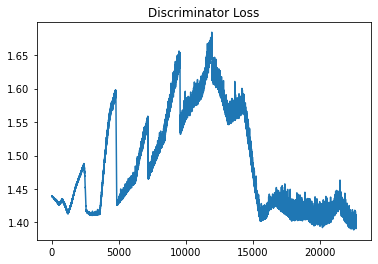

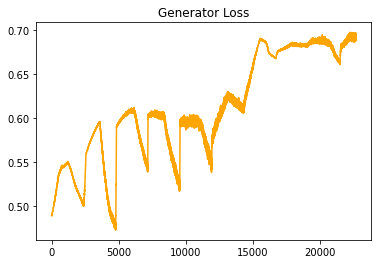

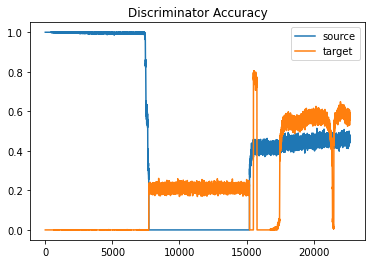

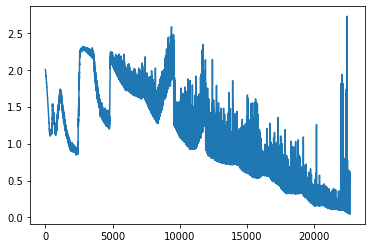

In [52]:
disc_loss_history = []
target_acc = []
source_acc = []
target_loss_history = []
gp = []

best_performance = 0
best_epoch=0
source_model = DoS_Classifier().to(device)
source_model.load_state_dict(torch.load('model_state_dict'))
source_model.eval()
for param in source_model.parameters():
    param.requires_grad = False
retrained_target_model = source_model
source_model = source_model.model_layers

target_model = DoS_Classifier().to(device)
target_model.load_state_dict(torch.load('model_state_dict'))
target_model = target_model.model_layers



criterion = nn.BCEWithLogitsLoss()
optimizer_target = optim.Adam(target_model.parameters(), lr=2e-4)#, betas=(0.5, 0.9))

adversarial_discriminator=adaption().to(device)
Adver_optimizer = optim.Adam(adversarial_discriminator.parameters(), lr=1e-4)#, betas=(0.5, 0.9))
scheduler = optim.lr_scheduler.StepLR(Adver_optimizer, 1,gamma=1)




for epoch in range(100): 
    check_target = copy.deepcopy(retrained_target_model)

    for i, batch in enumerate(train_dataloader_target):
        inputs_target, _ = batch
        inputs_target = inputs_target.to(device)

        # randomly select sourcce data
        rand_rows = torch.randperm(len(train_x))[:len(inputs_target)]
        inputs_source = train_x[rand_rows,:].to(device)

        # zero the parameter gradients
        Adver_optimizer.zero_grad()
        optimizer_target.zero_grad()

        # for p in adversarial_discriminator.parameters():
        #     if len(p.data)>1:
        #         p.data.clamp_(-.3, .3)

        # for p in target_model.parameters():
        #     p.data.clamp_(-1.0, 1.0)

        # # forward + backward + optimize
        Vec_source = source_model(inputs_source)

        Vec_target = target_model(inputs_target)

        output_source = adversarial_discriminator(Vec_source.detach())

        output_target = adversarial_discriminator(Vec_target.detach())

  

        neg_label = torch.zeros(len(output_target),1).to(device)
        pos_label = torch.ones(len(output_source),1).to(device)

        errD_source = criterion(output_source,pos_label)

        errD_target = criterion(output_target,neg_label)

        # errD_source = -torch.mean(output_source) 
        # errD_target = torch.mean(output_target)
        
        gradient_penalty = 2.5*get_gradient_penalty(adversarial_discriminator, Vec_source.data, Vec_target.data)
        gp.append(gradient_penalty.item())
        if epoch % 2 == 0:
            gradient_penalty.backward()
            errD_source.backward()
            errD_target.backward()
       

        Adver_optimizer.step()  


        errD = errD_target + errD_source

       

        output=adversarial_discriminator(Vec_target)

        err_target = criterion(output,pos_label)
        # err_target = -torch.mean(output)
        check_target.model_layers = target_model
        pred_y_target = check_target(inputs_target)
        pred_spread = 0.005/torch.var(pred_y_target)
        if epoch % 1 == 0:
        
            err_target.backward()
            pred_spread.backward()

            optimizer_target.step()


        disc_loss_history.append(errD.item())
        target_loss_history.append(err_target.item())
        target_acc.append(accuracy_score(np.round(torch.sigmoid(output_target).data.cpu().numpy()),neg_label.data.cpu().numpy()))
        source_acc.append(accuracy_score(np.round(torch.sigmoid(output_source).data.cpu().numpy()),pos_label.data.cpu().numpy()))


    scheduler.step()

    check_target.model_layers = target_model
    pred_y_target = check_target(train_x_target.to(device)).cpu().data.numpy()
    results = precision_recall_fscore_support(train_y_target.cpu().data,(pred_y_target>.5).astype('int'),average='binary')
    if  max(results[2],best_performance) > best_performance:
        best_epoch=epoch
    best_performance = max(results[2],best_performance)
    
    if best_performance>.7:

        break
    upper_lim=.55
    lower_lim=.45
    if target_acc[-1] < upper_lim and target_acc[-1] > lower_lim and source_acc[-1] < upper_lim and source_acc[-1] > lower_lim:
        break

    if epoch % 1 == 0:
        clear_output()     
        print(scheduler.get_lr())
        print(results)
        print("best F1: ",best_performance)
        print("best epoch: ", best_epoch)
        print("epoch: ", epoch+1)

        plt.plot(disc_loss_history)
        plt.title('Discriminator Loss')
        # plt.ylim(0,2)
        plt.show()

        plt.plot(target_loss_history,color='orange')
        plt.title('Generator Loss')

        plt.show()


        plt.plot(range(len(source_acc)),source_acc,range(len(target_acc)),target_acc)
        plt.legend(['source','target'])
        plt.title('Discriminator Accuracy')

        plt.show()

        plt.plot(gp)
        plt.show()

  
 

In [53]:
#  plt.xticks([e*(int(len(train_x_target)/1024) +len(train_x_target) % 1024)  for e in range(epoch+2)],range(epoch+1))


## Evaluation

In [54]:
source_model = DoS_Classifier().to(device)
source_model.load_state_dict(torch.load('model_state_dict'))

<All keys matched successfully>

In [55]:
retrained_target_model.model_layers=target_model

In [56]:
pred_y_target=source_model(train_x_target.to(device)).cpu().data.numpy()
precision_recall_fscore_support(train_y_target.cpu().data,(pred_y_target>.5).astype('int'),average='binary')

(0.3329988886144727, 0.17075892857142858, 0.22575345332775218, None)

(array([177337., 121603.,  79461., 706840.,  85308.,  27364.,  14613.,
          3877.,   4388.,   1830.]),
 array([0.16301738, 0.24671353, 0.33040968, 0.41410583, 0.497802  ,
        0.58149815, 0.6651943 , 0.74889046, 0.8325866 , 0.9162828 ,
        0.9999789 ], dtype=float32),
 <a list of 10 Patch objects>)

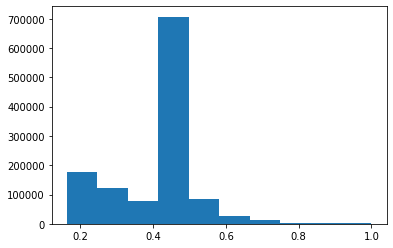

In [57]:
plt.hist(pred_y_target)

In [58]:
pred_y_target=retrained_target_model(train_x_target.to(device)).cpu().data.numpy()
precision_recall_fscore_support(train_y_target.cpu().data,(pred_y_target>.6).astype('int'),average='binary')

(0.12856510821652478, 0.3438726887031408, 0.18715703834062292, None)

In [59]:
# torch.save(retrained_target_model,'retrained_target_model.pt')

In [60]:
pred_y=source_model(test_x.to(device)).cpu().data.numpy()
precision_recall_fscore_support(test_y.cpu().data,(pred_y>.5).astype('int'),average='binary')

(0.36660029865604776, 0.7204695524578136, 0.48593814432989685, None)

In [61]:
##most optimal GAN

In [62]:
# disc_loss_history = []
# target_acc = []
# source_acc = []
# target_loss_history = []
# gp = []

# best_performance = 0
# best_epoch=0
# source_model = DoS_Classifier().to(device)
# source_model.load_state_dict(torch.load('model_state_dict'))
# source_model.eval()
# for param in source_model.parameters():
#     param.requires_grad = False
# retrained_target_model = source_model
# source_model = source_model.model_layers

# target_model = DoS_Classifier().to(device)
# target_model.load_state_dict(torch.load('model_state_dict'))
# target_model = target_model.model_layers



# criterion = nn.BCEWithLogitsLoss()
# optimizer_target = optim.Adam(target_model.parameters(), lr=2e-4)#, betas=(0.5, 0.9))

# adversarial_discriminator=adaption().to(device)
# Adver_optimizer = optim.Adam(adversarial_discriminator.parameters(), lr=1e-4)#, betas=(0.5, 0.9))
# scheduler = optim.lr_scheduler.StepLR(Adver_optimizer, 1,gamma=1)




# for epoch in range(100): 
#     check_target = copy.deepcopy(retrained_target_model)

#     for i, batch in enumerate(train_dataloader_target):
#         inputs_target, _ = batch
#         inputs_target = inputs_target.to(device)

#         # randomly select sourcce data
#         rand_rows = torch.randperm(len(train_x))[:len(inputs_target)]
#         inputs_source = train_x[rand_rows,:].to(device)

#         # zero the parameter gradients
#         Adver_optimizer.zero_grad()
#         optimizer_target.zero_grad()

#         # for p in adversarial_discriminator.parameters():
#         #     if len(p.data)>1:
#         #         p.data.clamp_(-.3, .3)

#         # for p in target_model.parameters():
#         #     p.data.clamp_(-1.0, 1.0)

#         # # forward + backward + optimize
#         Vec_source = source_model(inputs_source)

#         Vec_target = target_model(inputs_target)

#         output_source = adversarial_discriminator(Vec_source.detach())

#         output_target = adversarial_discriminator(Vec_target.detach())

  

#         neg_label = torch.zeros(len(output_target),1).to(device)
#         pos_label = torch.ones(len(output_source),1).to(device)

#         errD_source = criterion(output_source,pos_label)

#         errD_target = criterion(output_target,neg_label)

#         # errD_source = -torch.mean(output_source) 
#         # errD_target = torch.mean(output_target)
        
#         gradient_penalty = .7*get_gradient_penalty(adversarial_discriminator, Vec_source.data, Vec_target.data)
#         gp.append(gradient_penalty.item())
#         if epoch % 4 == 0:
#             gradient_penalty.backward()
#             errD_source.backward()
#             errD_target.backward()
       

#         Adver_optimizer.step()  


#         errD = errD_target + errD_source

       

#         output=adversarial_discriminator(Vec_target)

#         err_target = criterion(output,pos_label)
#         # err_target = -torch.mean(output)
#         check_target.model_layers = target_model
#         pred_y_target = check_target(inputs_target)
#         pred_spread = 0.005/torch.var(pred_y_target)
#         if epoch % 1 == 0:
        
#             err_target.backward()
#             pred_spread.backward()

#             optimizer_target.step()


#         disc_loss_history.append(errD.item())
#         target_loss_history.append(err_target.item())
#         target_acc.append(accuracy_score(np.round(torch.sigmoid(output_target).data.cpu().numpy()),neg_label.data.cpu().numpy()))
#         source_acc.append(accuracy_score(np.round(torch.sigmoid(output_source).data.cpu().numpy()),pos_label.data.cpu().numpy()))


#     scheduler.step()

#     check_target.model_layers = target_model
#     pred_y_target = check_target(train_x_target.to(device)).cpu().data.numpy()
#     results = precision_recall_fscore_support(train_y_target.cpu().data,(pred_y_target>.5).astype('int'),average='binary')
#     best_performance = max(results[2],best_performance)
#     if  max(results[2],best_performance) > best_performance:
#         best_epoch=epoch
#     if best_performance>.7:

#         break
#     if target_acc[-1] <.55 and target_acc[-1] > .45 and source_acc[-1] <.55 and source_acc[-1] > .45:
#         break

#     if epoch % 1 == 0:
#         clear_output()     
#         print(scheduler.get_lr())
#         print(results)
#         print("best F1: ",best_performance)
#         print("best epoch: ", best_epoch)
#         print("epoch: ", epoch+1)

#         plt.plot(disc_loss_history)
#         plt.title('Discriminator Loss')
#         # plt.ylim(0,2)
#         plt.show()

#         plt.plot(target_loss_history,color='orange')
#         plt.title('Generator Loss')

#         plt.show()


#         plt.plot(range(len(source_acc)),source_acc,range(len(target_acc)),target_acc)
#         plt.legend(['source','target'])
#         plt.title('Discriminator Accuracy')

#         plt.show()

#         plt.plot(gp)
#         plt.show()

  
 